In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
import xgboost as xgb
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor, early_stopping, log_evaluation
import shap

# Wrapper class for XGBoost to enable sklearn compatibility (if needed)
from sklearn.base import BaseEstimator, RegressorMixin
class XGBRegressorWrapper(BaseEstimator, RegressorMixin):
    def __init__(self, **params):
        self.params = params
        self.model = None
    def fit(self, X, y):
        self.model = xgb.XGBRegressor(**self.params)
        self.model.fit(X, y)
        return self
    def predict(self, X):
        if self.model is None:
            raise ValueError("Model has not been fitted yet!")
        return self.model.predict(X)
    def get_params(self, deep=True):
        return self.params
    def set_params(self, **params):
        self.params.update(params)
        return self

In [3]:
def load_data(train_path, test_path, submission_path):
    """Loads train, test, and sample submission data."""
    train = pd.read_csv(train_path)
    test = pd.read_csv(test_path)
    submission = pd.read_csv(submission_path)
    return train, test, submission

In [4]:
def preprocess_and_feature_engineer(train, test):
    """
    Cleans data, handles missing values, creates new features, and encodes categoricals.
    Returns processed X_train, X_test, y_train.
    """
    # Remove outliers (typical Kaggle trick for this dataset)
    outlier_idx = train[(train['GrLivArea'] > 4000) & (train['SalePrice'] < 300000)].index
    train = train.drop(outlier_idx).reset_index(drop=True)
    # Merge train and test for consistent preprocessing
    all_data = pd.concat([train.drop("SalePrice", axis=1), test], axis=0, sort=False).reset_index(drop=True)
    # Handle missing categorical features
    none_cols = ['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu',
                 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
                 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'MasVnrType']
    for col in none_cols:
        all_data[col] = all_data[col].fillna("None")
    # Handle missing numerical features
    zero_cols = ['GarageYrBlt', 'GarageArea', 'GarageCars', 'BsmtFinSF1',
                 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath',
                 'BsmtHalfBath', 'MasVnrArea']
    for col in zero_cols:
        all_data[col] = all_data[col].fillna(0)
    # Mode/most common value imputation for some columns
    mode_fill_cols = {
        "MSZoning": all_data["MSZoning"].mode()[0],
        "Electrical": all_data["Electrical"].mode()[0],
        "KitchenQual": all_data["KitchenQual"].mode()[0],
        "Exterior1st": all_data["Exterior1st"].mode()[0],
        "Exterior2nd": all_data["Exterior2nd"].mode()[0],
        "SaleType": all_data["SaleType"].mode()[0],
        "Functional": "Typ",
        "Utilities": all_data["Utilities"].mode()[0]
    }
    for col, fill_val in mode_fill_cols.items():
        all_data[col] = all_data[col].fillna(fill_val)
    # LotFrontage: fill by median per neighborhood
    all_data["LotFrontage"] = all_data.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))
    # Convert some numerics to categorical
    all_data["MSSubClass"] = all_data["MSSubClass"].astype(str)
    all_data["MoSold"] = all_data["MoSold"].astype(str)
    all_data["YrSold"] = all_data["YrSold"].astype(str)
    # Feature engineering
    all_data['TotalBath'] = (all_data['FullBath'] + all_data['BsmtFullBath'] +
                             0.5 * (all_data['HalfBath'] + all_data['BsmtHalfBath']))
    all_data['TotalSF'] = (all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF'])
    all_data['TotalRooms'] = all_data['TotRmsAbvGrd'] + all_data['BedroomAbvGr'] + all_data['KitchenAbvGr']
    all_data['TotalPorchSF'] = (all_data['OpenPorchSF'] + all_data['EnclosedPorch'] +
                                all_data['3SsnPorch'] + all_data['ScreenPorch'])
    all_data['IsRemodeled'] = (all_data['YearRemodAdd'] != all_data['YearBuilt']).astype(int)
    all_data['HouseAge'] = all_data['YrSold'].astype(int) - all_data['YearBuilt']
    all_data['GarageAge'] = all_data['YrSold'].astype(int) - all_data['GarageYrBlt']
    all_data['GarageAge'] = all_data['GarageAge'].replace([np.inf, -np.inf, np.nan], 0).clip(lower=0)
    all_data['GrLivArea_log'] = np.log1p(all_data['GrLivArea'])
    all_data['TotalSF_log'] = np.log1p(all_data['TotalSF'])
    all_data['OverallQual_bin'] = pd.qcut(all_data['OverallQual'], 4, labels=False)
    all_data['QualArea'] = all_data['OverallQual'] * all_data['GrLivArea']
    # Rare label grouping and label encoding for categoricals
    for col in all_data.select_dtypes(include='object'):
        freq = all_data[col].value_counts(normalize=True)
        rare = freq[freq < 0.01].index
        all_data[col] = all_data[col].replace(rare, 'Rare')
        lbl = LabelEncoder()
        all_data[col] = lbl.fit_transform(all_data[col].astype(str))
    # Re-split into train and test
    X_train = all_data.iloc[:train.shape[0], :].reset_index(drop=True)
    X_test = all_data.iloc[train.shape[0]:, :].reset_index(drop=True)
    y_train = np.log1p(train['SalePrice']).reset_index(drop=True)
    return X_train, X_test, y_train

In [5]:
def run_kfold_cv(X, y, base_model, n_splits=5):
    """
    Performs KFold cross-validation and returns OOF predictions, average test predictions, and fitted model.
    """
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    oof_preds = np.zeros(X.shape[0])
    models = []
    for fold, (train_idx, val_idx) in enumerate(kf.split(X), 1):
        print(f"\n--- Fold {fold} ---")
        X_tr, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_tr, y_val = y.iloc[train_idx], y.iloc[val_idx]
        model = base_model
        model.fit(
            X_tr, y_tr,
            eval_set=[(X_val, y_val)],
            eval_metric='rmse',
            callbacks=[early_stopping(stopping_rounds=100), log_evaluation(100)]
        )
        oof_preds[val_idx] = model.predict(X_val, num_iteration=model.best_iteration_)
        rmse = np.sqrt(mean_squared_error(y_val, oof_preds[val_idx]))
        print(f"Fold {fold} RMSE (log): {rmse:.5f}")
        models.append(model)
    print("\n=== KFold CV Completed ===")
    print("OOF RMSE (log):", np.sqrt(mean_squared_error(y, oof_preds)))
    oof_preds_real = np.expm1(oof_preds)
    y_real = np.expm1(y)
    print("OOF RMSE (USD):", np.sqrt(mean_squared_error(y_real, oof_preds_real)))
    return oof_preds, models

In [6]:
def hyperparameter_search(X, y, models, param_grids, model_names):
    """
    Performs hyperparameter optimization for a list of models.
    Returns a DataFrame of results and the best estimators.
    """
    cv_result = []
    best_estimators = []
    for i, model in enumerate(models):
        print(f"\n==== {model_names[i]} ====")
        try:
            clf = RandomizedSearchCV(
                model,
                param_distributions=param_grids[i],
                n_iter=20,
                cv=3,
                scoring="r2",
                n_jobs=-1,
                verbose=2,
                random_state=42
            )
            clf.fit(X, y)
            print(f"Best parameters for {model_names[i]}: {clf.best_params_}")
            print(f"Best CV Score (R2 - log SalePrice): {clf.best_score_:.5f}")
            cv_result.append({
                "Model": model_names[i],
                "Best Params": clf.best_params_,
                "Best CV Score": clf.best_score_
            })
            best_estimators.append(clf.best_estimator_)
        except Exception as e:
            print(f"Error with {model_names[i]}: {e}")
    cv_results = pd.DataFrame(cv_result)
    return cv_results, best_estimators

In [7]:
def evaluate_on_validation(model, X_val, y_val):
    """
    Evaluates the model on the given validation set and prints/plots results.
    """
    y_pred = model.predict(X_val)
    mae = mean_absolute_error(y_val, y_pred)
    mse = mean_squared_error(y_val, y_pred)
    rmse = mse ** 0.5
    r2 = r2_score(y_val, y_pred)
    print(f"Validation MAE: {mae:.2f}")
    print(f"Validation MSE: {mse:.2f}")
    print(f"Validation RMSE: {rmse:.2f}")
    print(f"Validation R²: {r2:.3f}")
    # Back-transform log predictions
    y_val_real = np.expm1(y_val)
    y_pred_real = np.expm1(y_pred)
    # Scatter plot
    plt.figure(figsize=(7, 7))
    plt.scatter(y_val_real, y_pred_real, alpha=0.4, color='royalblue')
    plt.plot([y_val_real.min(), y_val_real.max()], [y_val_real.min(), y_val_real.max()], 'r--', lw=2, label="Perfect Prediction (y=x)")
    plt.xlabel("Actual Values (SalePrice)")
    plt.ylabel("Predicted Values (SalePrice)")
    plt.title("Predicted vs. Actual Values (Validation Set)")
    plt.legend()
    plt.grid(True, alpha=0.2)
    plt.tight_layout()
    plt.show()
    # Residuals
    residuals = y_val_real - y_pred_real
    plt.figure(figsize=(8, 5))
    plt.scatter(y_val_real, residuals, alpha=0.5)
    plt.axhline(0, color='red', linestyle='--', lw=2)
    plt.xlabel("Actual Values (SalePrice)")
    plt.ylabel("Prediction Error (Residuals)")
    plt.title("Residual Plot")
    plt.tight_layout()
    plt.show()
    # Absolute residuals
    abs_residuals = np.abs(residuals)
    plt.figure(figsize=(8, 5))
    plt.hist(abs_residuals, bins=30, color='cornflowerblue', edgecolor='k', alpha=0.7)
    plt.title('Distribution of Absolute Prediction Errors')
    plt.xlabel('|Error| (|Actual - Predicted|)')
    plt.ylabel('Frequency')
    plt.grid(alpha=0.2)
    plt.tight_layout()
    plt.show()
    print(f"Mean absolute error: {abs_residuals.mean():.2f}")
    print(f"Median absolute error: {np.median(abs_residuals):.2f}")
    print(f"Max absolute error: {abs_residuals.max():.2f}")

In [8]:
def plot_feature_importance(model, feature_names, top_n=20, model_title="Model"):
    """Plots the top N feature importances for the given model."""
    importances = model.feature_importances_
    feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)[:top_n]
    plt.figure(figsize=(8, 6))
    sns.barplot(x=feat_imp.values, y=feat_imp.index, palette='viridis')
    plt.title(f"Top {top_n} Feature Importances ({model_title})")
    plt.xlabel("Importance Score")
    plt.tight_layout()
    plt.show()

In [9]:
def plot_shap_summary(model, X_train, model_name="Model"):
    """Plots SHAP summary plot for the given model and training data."""
    explainer = shap.Explainer(model, X_train)
    shap_values = explainer(X_train)
    shap.summary_plot(shap_values, X_train, show=True)
    # Example for the first sample
    shap.plots.waterfall(shap_values[0], max_display=10)

In [10]:
def create_submission_file(best_model, X_test, test_df, filename="/kaggle/working/submission.csv"):
    """
    Generates a Kaggle submission file using the best trained model.
    The output will be saved as filename (default: submission.csv).
    """
    # Predict log(SalePrice), then inverse transform
    y_test_pred_log = best_model.predict(X_test)
    y_test_pred = np.expm1(y_test_pred_log)
    # If test set has Id column (from original test.csv), use it. Else, create Id as sequential.
    if "Id" in test_df.columns:
        submission = pd.DataFrame({
            "Id": test_df["Id"],
            "SalePrice": y_test_pred
        })
    else:
        submission = pd.DataFrame({
            "Id": np.arange(1461, 1461 + len(X_test)),  # default kaggle test set id start
            "SalePrice": y_test_pred
        })
    submission.to_csv(filename, index=False)
    print(f"Submission file '{filename}' successfully created.")


=== KFold Cross-Validation (LGBMRegressor) ===

--- Fold 1 ---
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004988 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4552
[LightGBM] [Info] Number of data points in the train set: 991, number of used features: 83
[LightGBM] [Info] Start training from score 12.021430
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.205941	valid_0's l2: 0.0424116
[200]	valid_0's rmse: 0.152414	valid_0's l2: 0.0232299
[300]	valid_0's rmse: 0.139306	valid_0's l2: 0.0194061
[400]	valid_0's rmse: 0.134899	valid_0's l2: 0.0181977
[500]	valid_0's rmse: 0.13308	valid_0's l2: 0.0177104
[600]	valid_0's rmse: 0.131897	valid_0's l2: 0.0173968
[700]	valid_0's rmse: 0.1316	valid_0's l2: 0.0173185
[800]	valid_0's rmse: 0.131633	valid_0's l2: 0.0173273
Early stopping, best iteration i

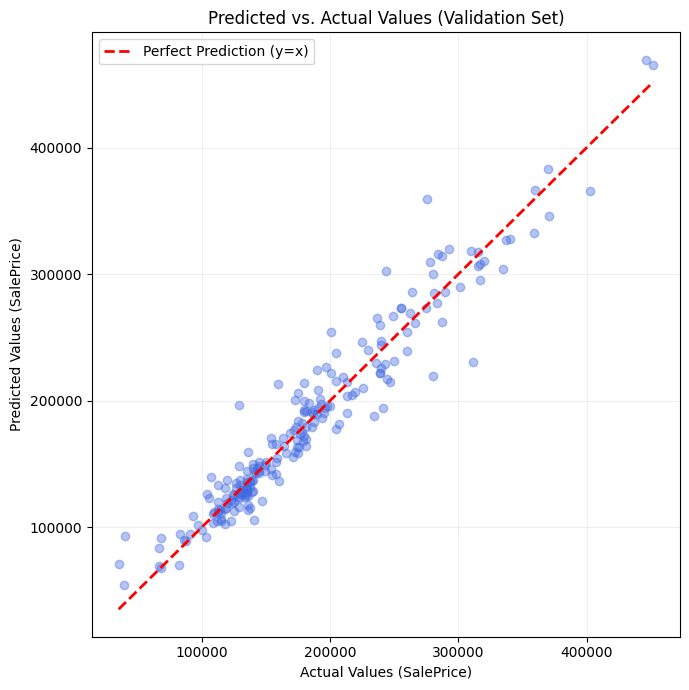

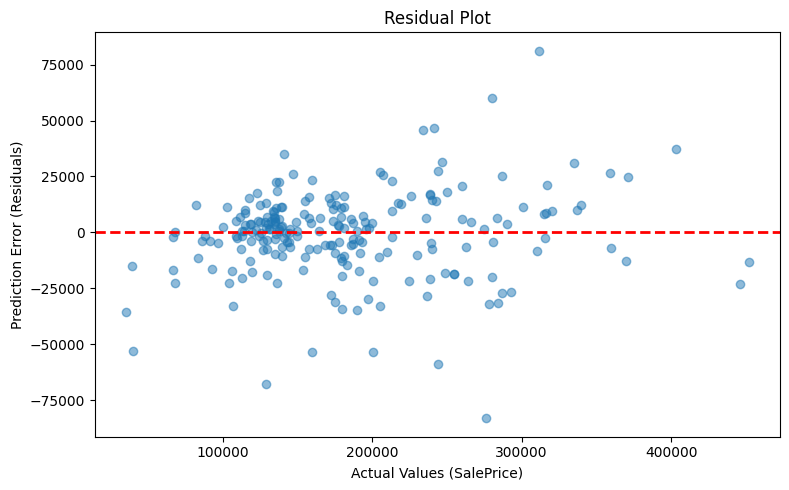

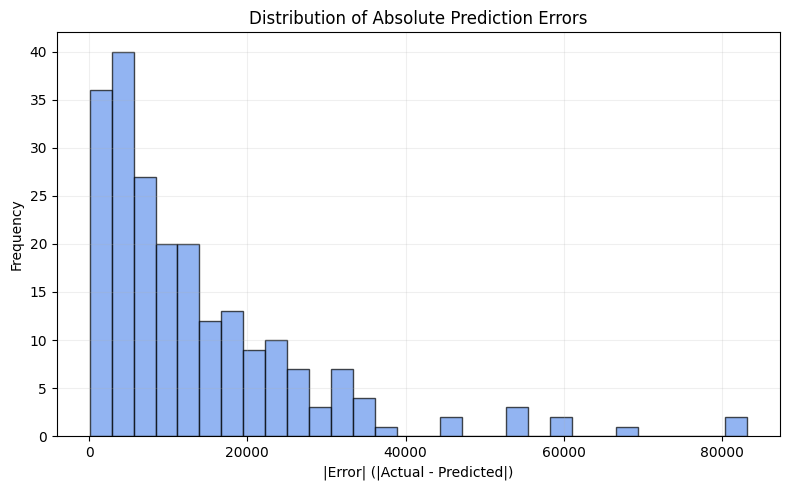

Mean absolute error: 13562.17
Median absolute error: 9408.59
Max absolute error: 83158.39


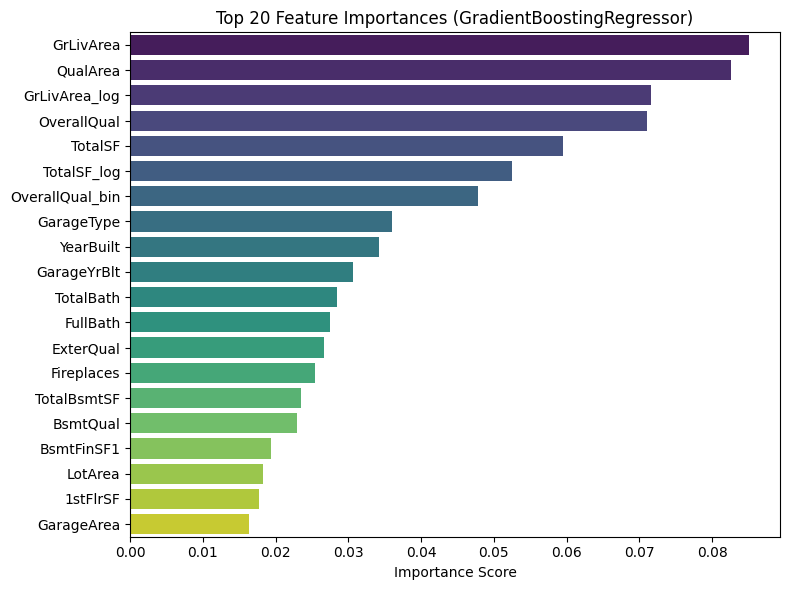

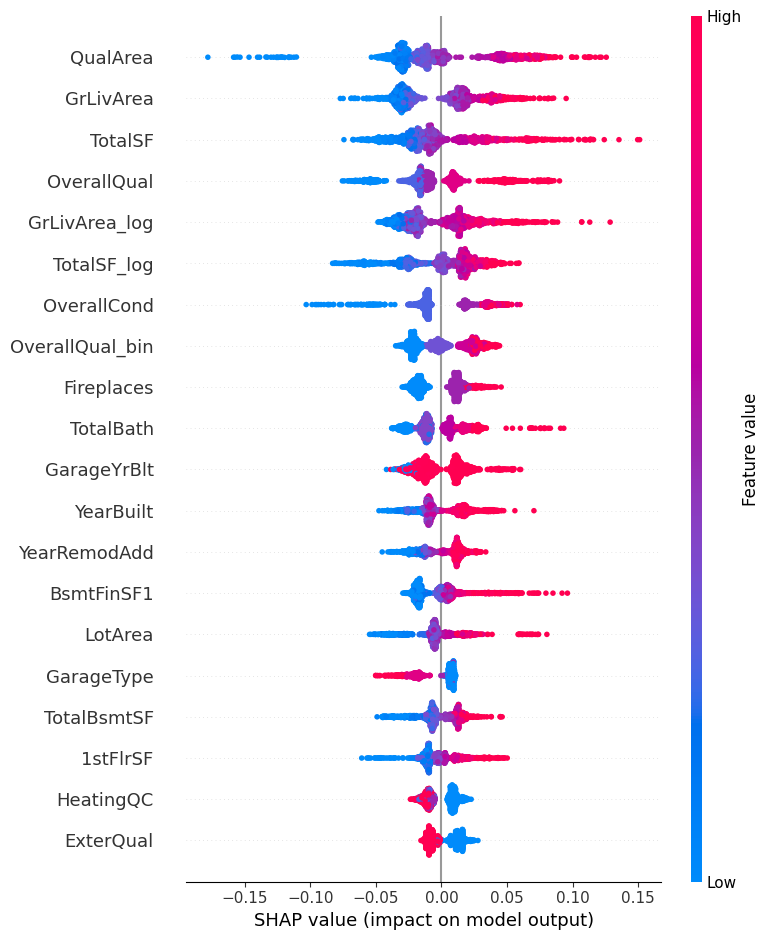

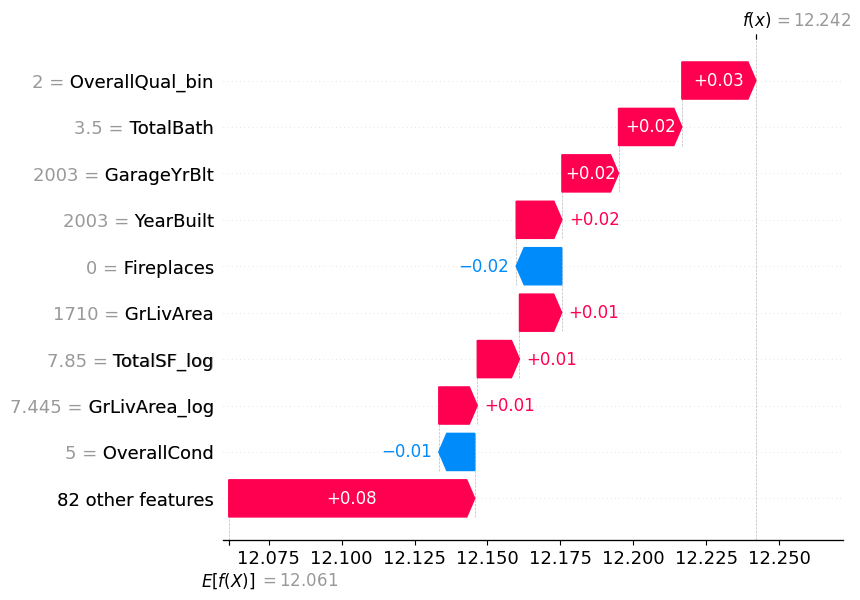

Submission file '/kaggle/working/submission.csv' successfully created.


In [11]:
# ==== PIPELINE EXECUTION ====
if __name__ == "__main__":
    # 1. Load data
    train, test, submission = load_data(
    '/kaggle/input/house-prices-advanced-regression-techniques/train.csv',
    '/kaggle/input/house-prices-advanced-regression-techniques/test.csv',
    '/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv'
    )
    # 2. Data cleaning and feature engineering
    X_train, X_test, y_train = preprocess_and_feature_engineer(train, test)
    # 3. Train/validation split (15% for validation)
    X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=42)
    # 4. Run KFold cross-validation for a baseline LGBM model
    print("\n=== KFold Cross-Validation (LGBMRegressor) ===")
    lgbm_params = dict(
        n_estimators=1000, learning_rate=0.01, num_leaves=31, max_depth=-1,
        subsample=0.8, colsample_bytree=0.8, random_state=42, n_jobs=-1
    )
    lgbm_model = LGBMRegressor(**lgbm_params)
    oof_preds, _ = run_kfold_cv(X_tr, y_tr, lgbm_model)
    # 5. Hyperparameter optimization for multiple models
    models = [
        GradientBoostingRegressor(random_state=42),
        RandomForestRegressor(random_state=42),
        XGBRegressorWrapper(random_state=42, verbosity=0),
        CatBoostRegressor(random_state=42, verbose=False),
        LGBMRegressor(random_state=42, verbose=-1)
    ]
    param_grids = [
        {
            "n_estimators": [100, 200, 300],
            "learning_rate": [0.01, 0.05, 0.1],
            "max_depth": [3, 5, 7],
            "min_samples_split": [2, 5],
            "min_samples_leaf": [1, 2],
            "subsample": [0.8, 1.0],
            "max_features": ["sqrt", "log2"]
        },
        {
            "n_estimators": [100, 200, 500],
            "max_depth": [None, 10, 20, 30],
            "min_samples_split": [2, 5, 10],
            "min_samples_leaf": [1, 2, 4],
            "max_features": ["sqrt", "log2", None]
        },
        {
            "n_estimators": [100, 200, 300],
            "learning_rate": [0.01, 0.05, 0.1],
            "max_depth": [3, 5, 7],
            "subsample": [0.8, 1.0],
            "colsample_bytree": [0.8, 1.0],
            "gamma": [0, 1, 5]
        },
        {
            "iterations": [100, 200, 300],
            "learning_rate": [0.01, 0.05, 0.1],
            "depth": [3, 5, 7],
            "l2_leaf_reg": [1, 3, 5],
            "bagging_temperature": [0, 1],
            "border_count": [32, 64, 128]
        },
        {
            "n_estimators": [100, 200, 300],
            "learning_rate": [0.01, 0.05, 0.1],
            "max_depth": [3, 5, 7, -1],
            "num_leaves": [31, 50, 100],
            "subsample": [0.8, 1.0],
            "colsample_bytree": [0.8, 1.0]
        }
    ]
    model_names = [
        "GradientBoostingRegressor",
        "RandomForestRegressor",
        "XGBRegressor",
        "CatBoostRegressor",
        "LGBMRegressor"
    ]
    cv_results, best_estimators = hyperparameter_search(X_tr, y_tr, models, param_grids, model_names)
    print("\n==== ALL RESULTS ====")
    print(cv_results)
    # 6. Evaluate the best model on the held-out validation set
    best_model_name = cv_results.loc[cv_results["Best CV Score"].idxmax(), "Model"]
    best_params = cv_results.loc[cv_results["Best CV Score"].idxmax(), "Best Params"]
    print(f"Best Model: {best_model_name}")
    print(f"Best Parameters: {best_params}")
    # Dynamically instantiate the best model
    model_mapping = {
        "GradientBoostingRegressor": GradientBoostingRegressor,
        "RandomForestRegressor": RandomForestRegressor,
        "XGBRegressor": xgb.XGBRegressor,
        "CatBoostRegressor": CatBoostRegressor,
        "LGBMRegressor": LGBMRegressor,
    }
    best_model_class = model_mapping[best_model_name]
    best_model = best_model_class(**best_params)
    best_model.fit(X_tr, y_tr)
    # Evaluate and plot
    evaluate_on_validation(best_model, X_val, y_val)
    # Feature importance and SHAP
    plot_feature_importance(best_model, X_train.columns, top_n=20, model_title=best_model_name)
    plot_shap_summary(best_model, X_train, model_name=best_model_name)
    create_submission_file(best_model, X_test, test, filename="/kaggle/working/submission.csv")

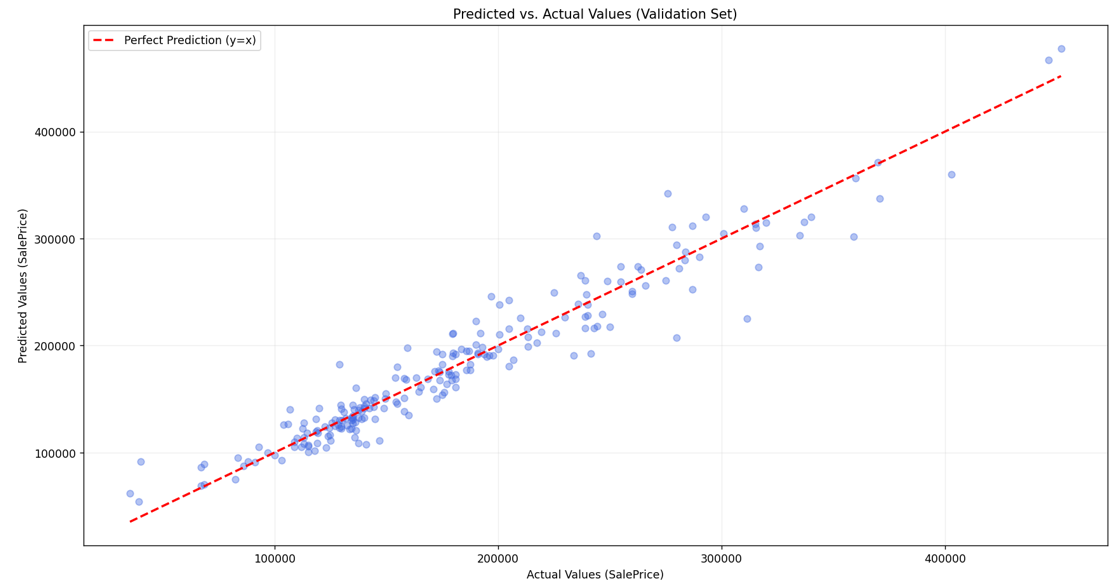

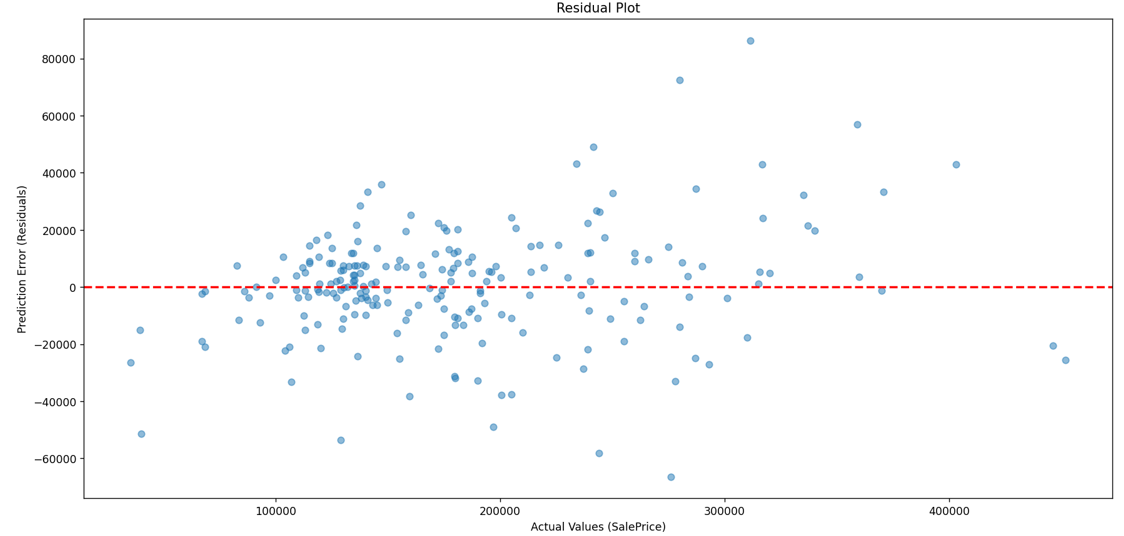

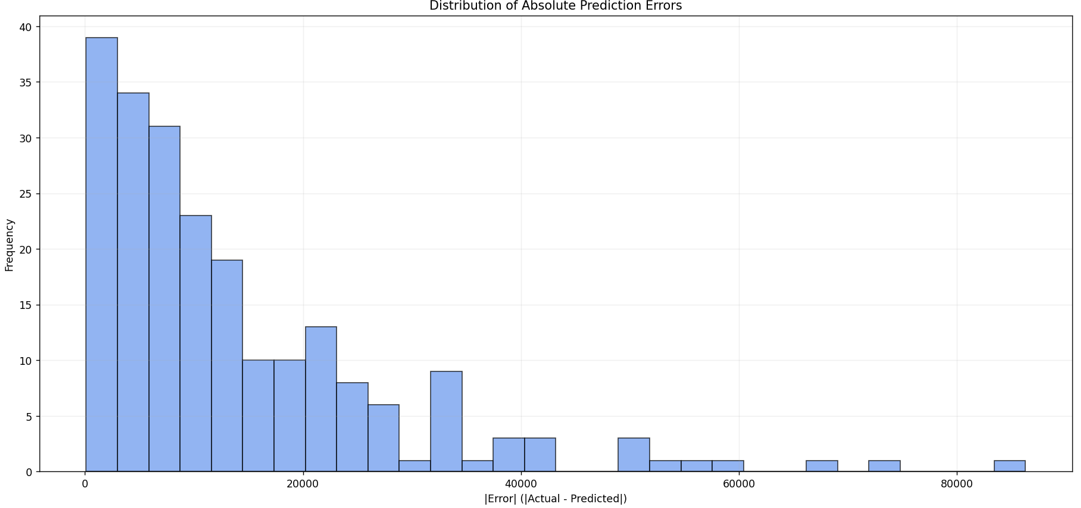

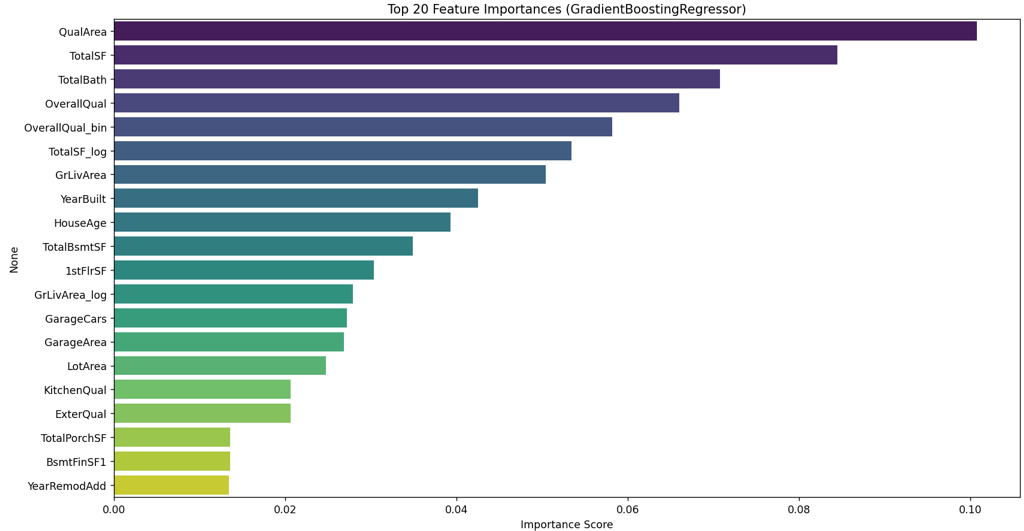

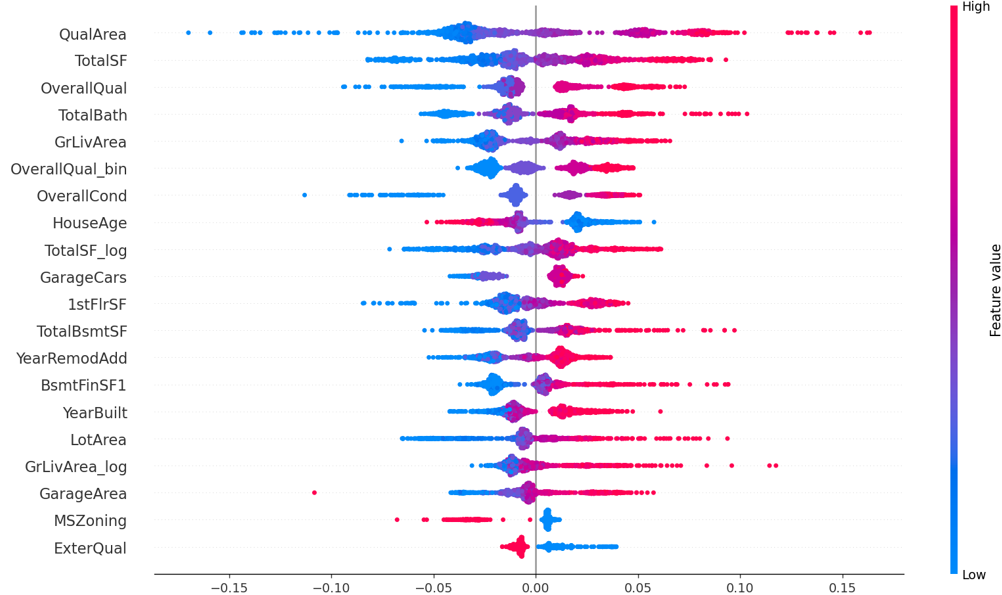

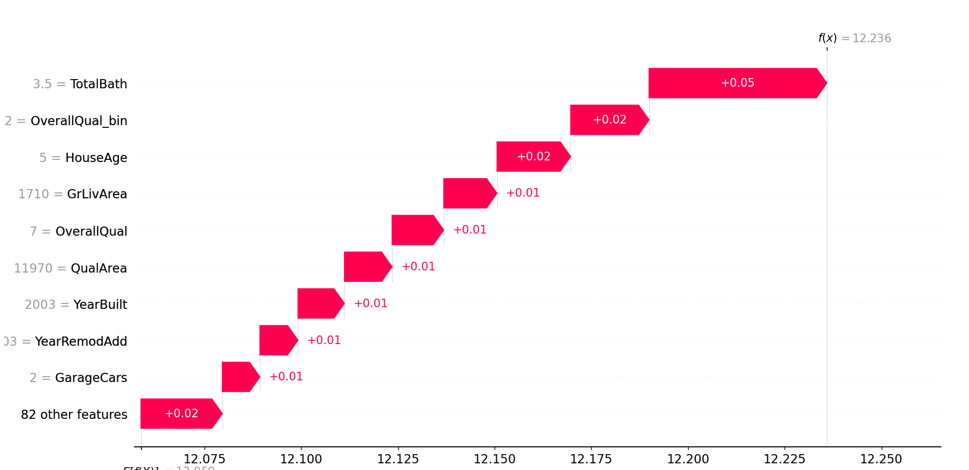